<a href="https://colab.research.google.com/github/Aru-14/AICTE_Internship_Garbage_Collection/blob/main/Week%201/GarbageCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2




In [21]:
dataset_dir=r"TrashType_Image_Dataset"
image_size = (224,224)
batch_size = 32
seed= 42

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [24]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 5)
val_dat = val_ds.skip(val_batches // 5)

test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [25]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


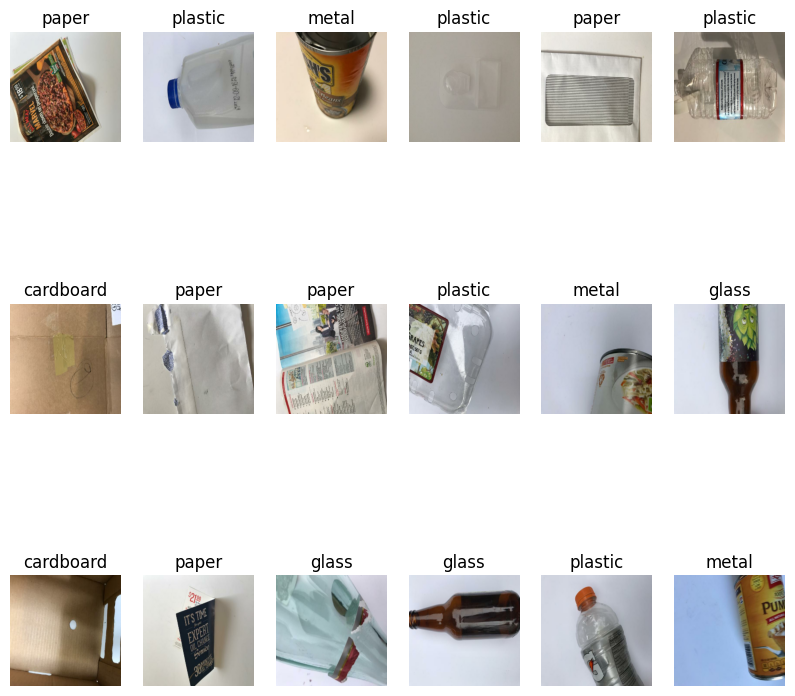

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(2):
  for i in range(18):
    ax = plt.subplot(3,6,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [27]:
def count_distribution(dataset, class_names):
  total = 0
  counts = {name: 0 for name in class_names}

  for _, labels in dataset:
    for label in labels.numpy():
      class_name = class_names[int(label)]
      counts[class_name] += 1
      total += 1

  for k in counts:
    counts[k] = round((counts[k]/total)*100,2)

  return counts

In [28]:
def simple_bar_plot(dist, title):
  plt.bar(dist.keys(), dist.values(), color = "salmon")
  plt.title(title)
  plt.ylabel('Percentage (%)')
  plt.xticks(rotation = 50)
  plt.ylim(0, 100)
  plt.tight_layout()
  plt.show()

In [29]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
  overall_dist[k] = round((train_dist[k] + val_dist[k])/2,2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 9.38, 'glass': 21.88, 'metal': 20.83, 'paper': 26.04, 'plastic': 18.75, 'trash': 3.12}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


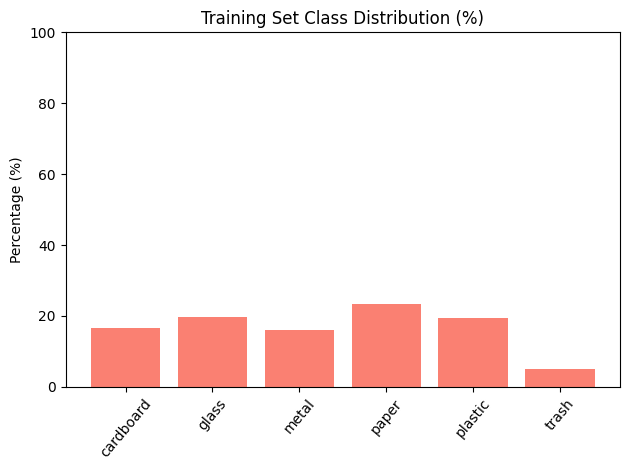

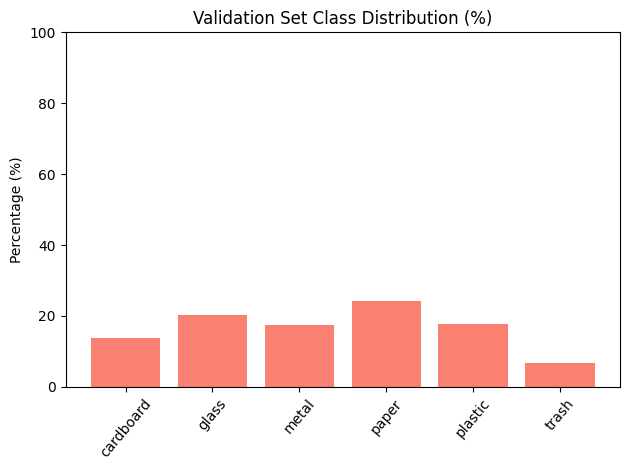

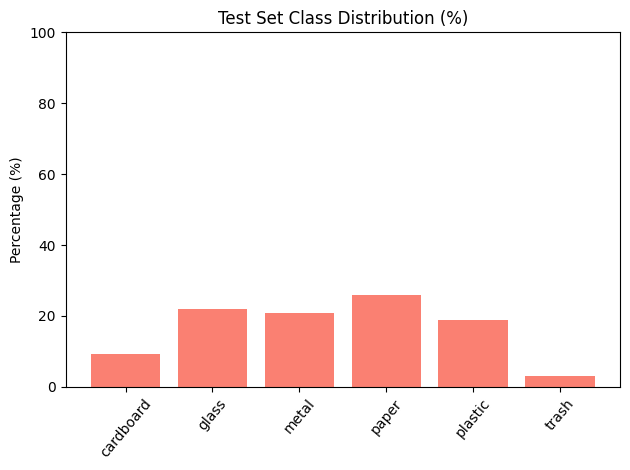

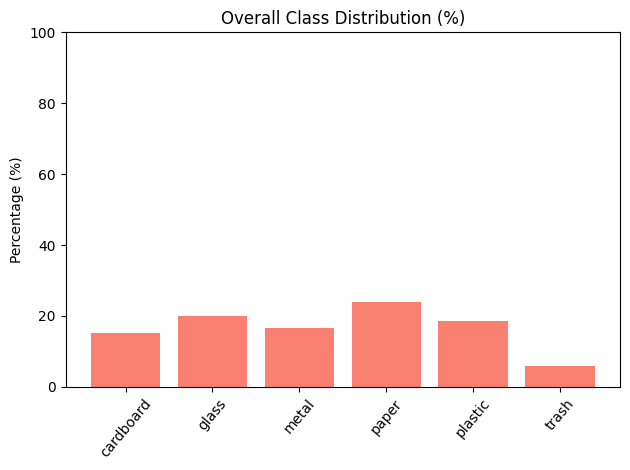

In [30]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [31]:
class_counts = {i:0 for i in range(len(class_names))}
all_labels=[]

for images, labels in train_ds:
  for label in labels.numpy():
    class_counts[int(label)] += 1
    all_labels.append(int(label))

class_weights_array = compute_class_weight(
    class_weight = "balanced",
    classes = np.arange(len(class_names)),
    y = all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [32]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

In [33]:
base_model = EfficientNetV2B2(include_top= False, input_shape=(224,224,3),include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable = False

In [34]:
model = Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [35]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [36]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 3,
    restore_best_weights=True

)

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    class_weight = class_weights,
    callbacks = [early]
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.1492 - loss: 1.8508 - val_accuracy: 0.1842 - val_loss: 1.7815
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2555 - loss: 1.7559 - val_accuracy: 0.3208 - val_loss: 1.6771
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3529 - loss: 1.6542 - val_accuracy: 0.4337 - val_loss: 1.5871
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.4339 - loss: 1.5358 - val_accuracy: 0.4950 - val_loss: 1.5031
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5097 - loss: 1.4351 - val_accuracy: 0.5842 - val_loss: 1.4026
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5524 - loss: 1.3780 - val_accuracy: 0.6158 - val_loss: 1.3124
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6157 - loss: 1.2670 - val_accuracy: 0.6416 - val_loss: 1.2496
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6346 - loss: 1.1945 - val_accuracy: 0.6792 - val_

In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [ ]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

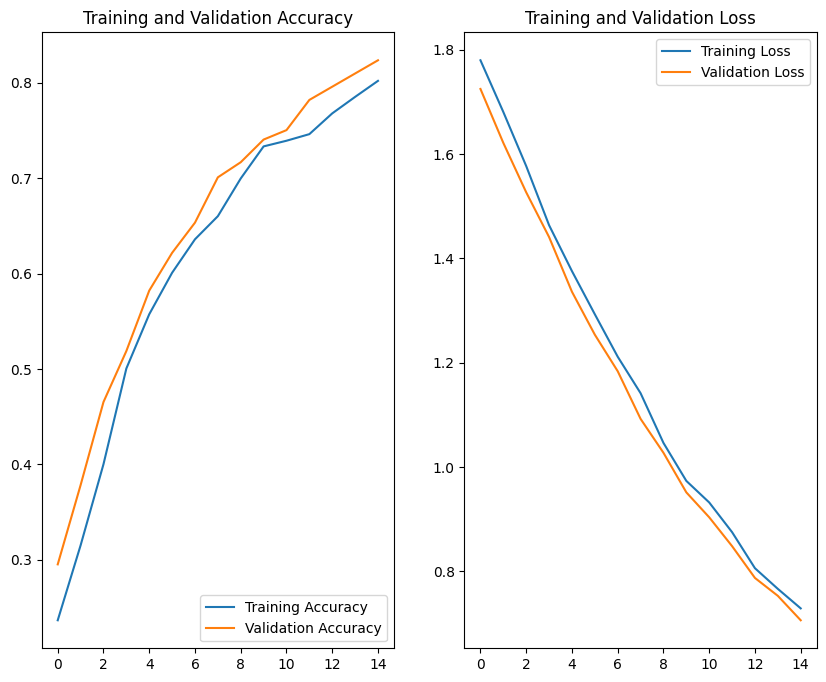

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range=range(len(acc))

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds_eval)
print('Test accuracy :', accuracy, 'Test loss is:', loss)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.8255 - loss: 0.7423
Test accuracy : 0.8229166865348816 Test loss is: 0.7604045867919922


In [ ]:
y_true = np.concatenate([y.numpy() for x,y in test_ds_eval], axis=0)

y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step
[[ 8  0  1  1  0  2]
 [ 0 18  2  0  0  0]
 [ 0  0 13  0  0  1]
 [ 2  0  0 19  0  3]
 [ 0  0  0  0 14  2]
 [ 1  0  1  0  1  7]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       1.00      0.90      0.95        20
           2       0.76      0.93      0.84        14
           3       0.95      0.79      0.86        24
           4       0.93      0.88      0.90        16
           5       0.47      0.70      0.56        10

    accuracy                           0.82        96
   macro avg       0.81      0.81      0.80        96
weighted avg       0.85      0.82      0.83        96



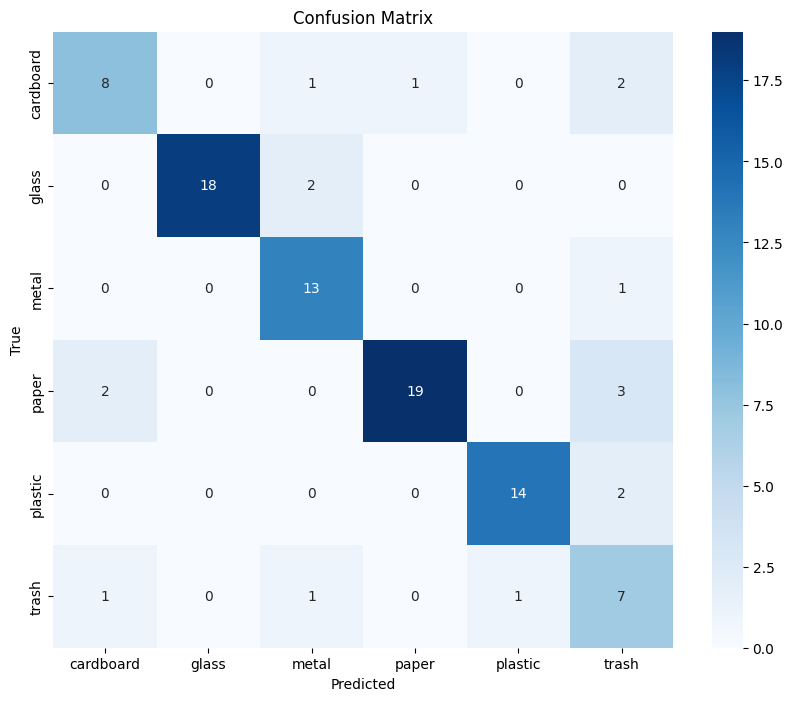

In [ ]:
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


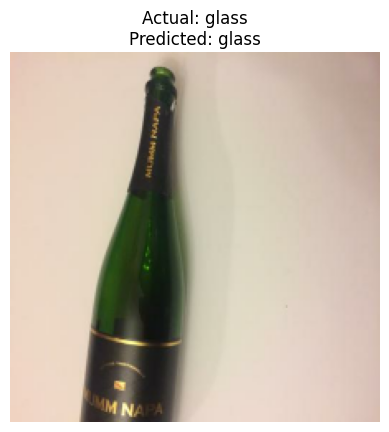

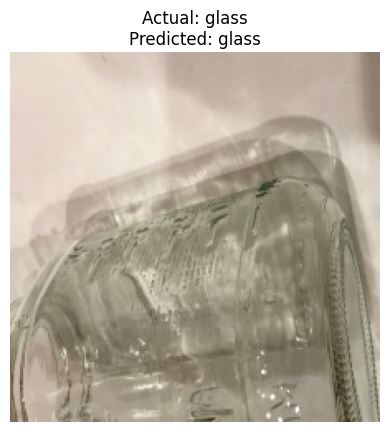

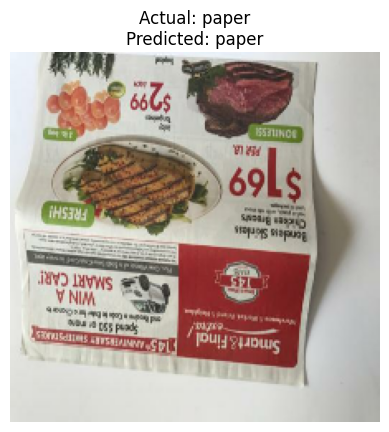

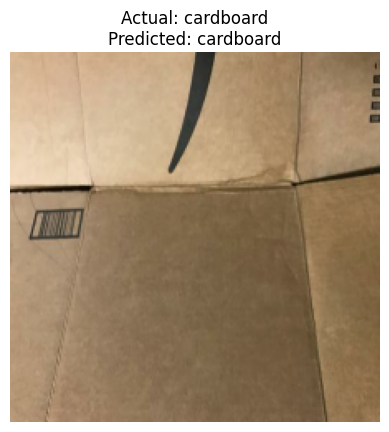

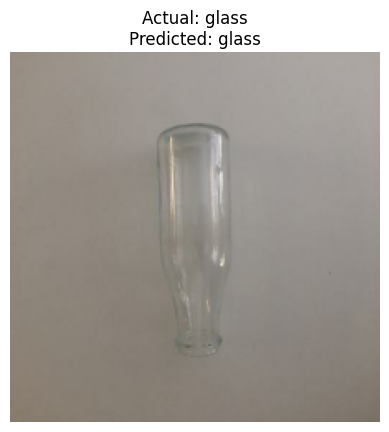

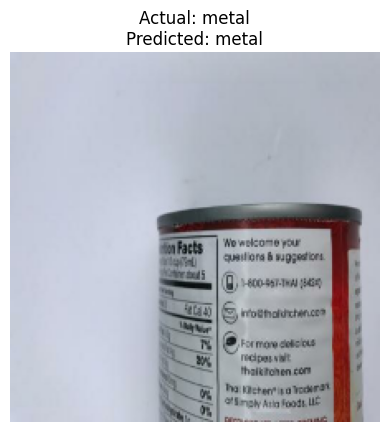

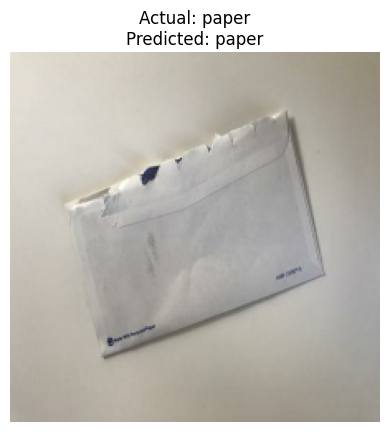

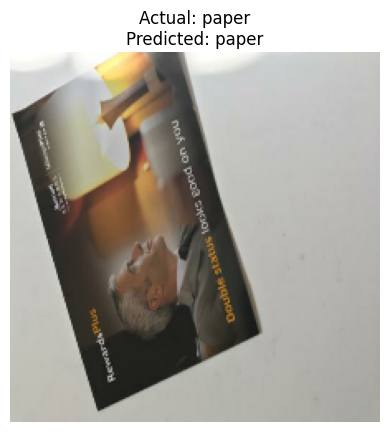

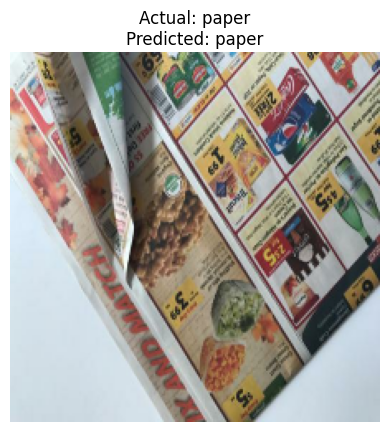

In [ ]:
class_names = train_ds.class_names

for images, labels in test_ds_eval.take(1):
  predictions = model.predict(images)
  pred_labels = tf.argmax(predictions, axis=1)

  for i in range(9):

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[pred_labels[i]]}")
    plt.axis("off")
    plt.show()

In [ ]:
model.save("model.h5")


In [ ]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install -q streamlit
!npm install -g localtunnel




[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
npm error code ENOENT
npm error syscall getaddrinfo
npm error errno ENOENT
npm error enoent request to https://registry.npmjs.org/localtunnel failed, reason: getaddrinfo ENOENT registry.npmjs.org
npm error enoent This is related to npm not being able to find a file.
npm error enoent
npm error A complete log of this run can be found in: C:\Users\ARUNIMA\AppData\Local\npm-cache\_logs\2025-07-01T11_32_41_058Z-debug-0.log


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
import tensorflow as tf
import numpy as np

# Load model
model = tf.keras.models.load_model("model.h5")
IMG_SIZE = (224, 224)

# Class names from train_ds.class_names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

st.title("Garbage Classifier")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded image", use_container_width=True)

    image = image.resize(IMG_SIZE)
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)

    prediction = model.predict(image_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    st.write(f"This is a {predicted_class}")
    st.write(f"Confidence: {confidence * 100:.2f}%")



Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501


^C
